In [1]:
#mount my drive to colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from tensorflow.python import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import cv2
import glob
import statistics 
from statistics import mode

Using TensorFlow backend.


In [3]:
base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(300, 300, 3))

W0718 14:08:06.110000 139997671135104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 14:08:06.145594 139997671135104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 14:08:06.157252 139997671135104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0718 14:08:06.191041 139997671135104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0718 14:08:06.192022

94658560/94653016 [==============================] - 1s 0us/step


In [6]:
TRAIN_DIR = '/content/drive/My Drive/Sign language proj/Data/train'
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)

Found 15039 images belonging to 10 classes.


In [5]:
VAL_DIR = '/content/drive/My Drive/Sign language proj/Data/val'
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

val_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(VAL_DIR, 
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)

Found 2816 images belonging to 10 classes.


## Building the model

In [7]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
       
    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS,
                                      num_classes=10)                             

W0718 14:10:32.649986 139997671135104 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Train the model

W0718 14:11:17.365897 139997671135104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0718 14:11:17.467136 139997671135104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/2
1879/1879 [==============================] - 673s 358ms/step - loss: 0.6090 - acc: 0.8217 - val_loss: 0.1836 - val_acc: 0.9396

Epoch 00001: saving model to /content/drive/My Drive/Sign language proj/weights-test.h5
Epoch 2/2
1879/1879 [==============================] - 466s 248ms/step - loss: 0.1236 - acc: 0.9610 - val_loss: 0.0856 - val_acc: 0.9695

Epoch 00002: saving model to /content/drive/My Drive/Sign language proj/weights-test.h5


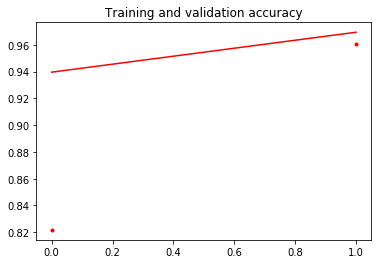

<Figure size 432x288 with 0 Axes>

In [8]:
NUM_EPOCHS = 2
BATCH_SIZE = 8
num_train_images = 15039
num_val_images = 2816 

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath="/content/drive/My Drive/Sign language proj/" + "weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(generator=train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE,
                                       validation_data=val_generator, 
                                       validation_steps=num_val_images // BATCH_SIZE,
                                       shuffle=True, callbacks=callbacks_list)

# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.show()
    plt.savefig('acc_vs_epochs.png')


plot_training(history)



## Test one pic

In [13]:
finetune_model.load_weights('/content/drive/My Drive/Sign language proj/weights.h5')                                     
finetune_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.1), metrics=['accuracy'])
 
class_list = ["ana","close","continue","eat","fen","listen","open","short","tall","watch"]

filenames = glob.glob("/content/drive/My Drive/Sign language proj/Data/test/open/open.161.jpg")
filenames.sort()
images = [cv2.imread(img) for img in filenames]

for img in images:
  img = cv2.resize(img,(300,300))
  img = np.reshape(img,[1,300,300,3])
  classint = finetune_model.predict(img)[0]
  classstr = class_list[classint.argmax()]

print(classstr)

open


## Test one class

In [17]:
finetune_model.load_weights('/content/drive/My Drive/Sign language proj/weights.h5')                                     
finetune_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.1), metrics=['accuracy'])
 
class_list = ["ana","close","continue","eat","fen","listen","open","short","tall","watch"]

res = {}
filenames = glob.glob("/content/drive/My Drive/Sign language proj/Data/test/open/*.jpg")
filenames.sort()
images = [cv2.imread(img) for img in filenames]
clist = []
for img in images:
  img = cv2.resize(img,(300,300))
  img = np.reshape(img,[1,300,300,3])
  classes = finetune_model.predict(img)[0]
  clist.append(class_list[classes.argmax()])

def most_common(List): 
    return(mode(List)) 
percent = np.around(clist.count(most_common(clist))/len(clist)*100)
res.update({most_common(clist):percent})
print("Accuracy: "+str(percent)+" %")
print(most_common(clist))

Accuracy: 69.0 %
open


## Test all data

In [16]:
finetune_model.load_weights('/content/drive/My Drive/Sign language proj/weights.h5')                                     
finetune_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.1), metrics=['accuracy'])
 
class_list = ["ana","close","continue","eat","fen","listen","open","short","tall","watch"]

res = {}
for obj in class_list:
  filenames = glob.glob("/content/drive/My Drive/Sign language proj/Data/test/"+obj+"/*.jpg")
  filenames.sort()
  images = [cv2.imread(img) for img in filenames]
  clist = []
  for img in images:
    img = cv2.resize(img,(300,300))
    img = np.reshape(img,[1,300,300,3])
    classes = finetune_model.predict(img)[0]
    clist.append(class_list[classes.argmax()])

  def most_common(List): 
      return(mode(List)) 
  percent = np.around(clist.count(most_common(clist))/len(clist)*100)
  res.update({most_common(clist):percent})
  #print("Accuracy: "+str(percent)+" %")
  #print(most_common(clist))
print(res)

{'ana': 93.0, 'close': 70.0, 'continue': 100.0, 'eat': 100.0, 'fen': 99.0, 'listen': 96.0, 'open': 69.0, 'short': 94.0, 'tall': 100.0, 'watch': 91.0}


In [0]:
json_string = finetune_model.to_json()
with open('/content/drive/My Drive/Sign language proj/model.json','w') as json_file:
  json_file.write(json_string)
finetune_model.save_weights('/content/drive/My Drive/Sign language proj/weights.h5')
print("finiish")


finiish
